In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
from scipy import stats
from scipy.optimize import curve_fit

The dataframe contains data taken triggering with an external test pulse with different phases (relative to the clock). From 0 degrees to 360 with a step of 10 degrees (the "delay" column)

In [3]:
df = pd.read_hdf('calibration_tpulse.h5')

In [4]:
df.head()

,evt_number,card_id,tofpet_id,wordtype_id,channel_id,sensor_id,tac_id,tcoarse,ecoarse,tfine,efine,delay
0,1,0,0,2,0,18,3,52477,354,929,231,0
1,1,0,0,2,0,18,0,59603,312,944,228,0
2,1,0,0,2,0,18,1,1193,270,932,242,0
3,1,0,0,2,0,18,2,8319,228,924,215,0
4,1,0,0,2,0,18,3,15445,186,913,218,0


We want to see the tfine distribution for each phase, to understand how it changes. First, we can do a histogram:

In [5]:
def compute_normalized_histogram(values, hist_range, bins):
    counts, xedges = np.histogram(values, range=hist_range, bins=bins)
    xstep  = xedges[1] - xedges[0]
    xs     = xedges[:-1] + xstep/2
    counts = counts / counts.sum()
    return counts, xs

In [6]:
def plot_phase_histograms(df, hist_range, bins, phases, text=True, offset=0):
    fig, ax = plt.subplots(figsize=(10,7))
    plt.rc('font', size=12)
    ax = plt.subplot(1, 1, 1)

    for phase in phases:
        tfines = df[df.delay == phase].tfine.values
        counts, xs = compute_normalized_histogram(tfines, hist_range, bins)

        plt.hist(xs, weights=counts, range=hist_range, bins=bins, alpha=0.5, label="Phase {}".format(phase))
        if text:
            plt.text(counts.argmax() + offset, 0.04, f"{phase}", horizontalalignment='center', verticalalignment='center', rotation=90, fontsize=18)

    plt.ylim(0, 0.05)

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')

In [7]:
bins       = 1024
hist_range = np.array([0, 1024])
phases     = np.arange(0, 360, 30)

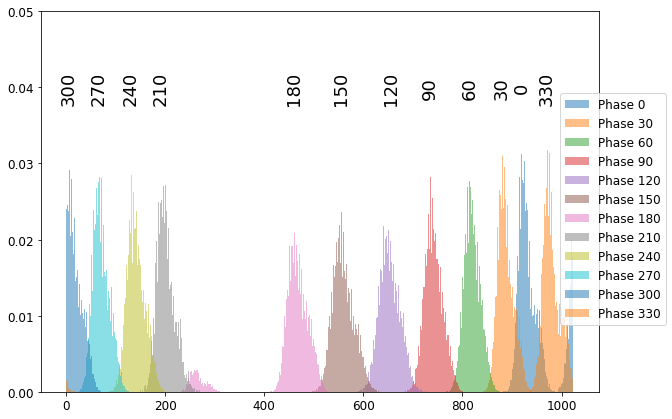

In [8]:
plot_phase_histograms(df, hist_range, bins, phases)

We have to correct the counter overflow:

In [9]:
offset = 380
df.loc[df['tfine'] < offset, 'tfine'] += 1024

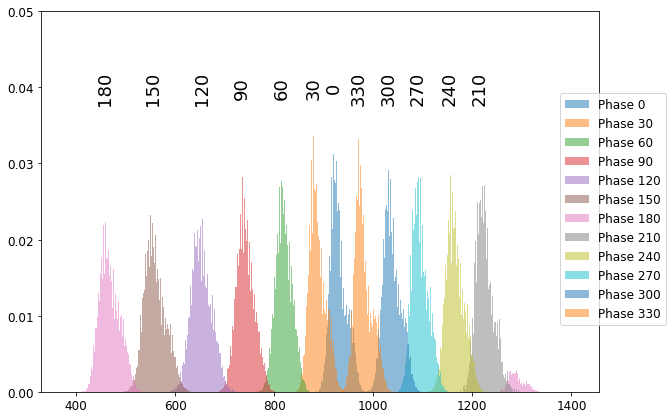

In [10]:
plot_phase_histograms(df, hist_range+offset, bins, phases, offset=offset)

Just taking the position of the maximum for each curve, we can see the expected plot for this calibration:

In [11]:
peaks = {}
phases = df.delay.unique()

for phase in phases:
    tfines = df[df.delay == phase].tfine.values
    peak = stats.mode(tfines).mode[0]
    peaks[phase] = peak

Text(0, 0.5, 'Corrected tfine')

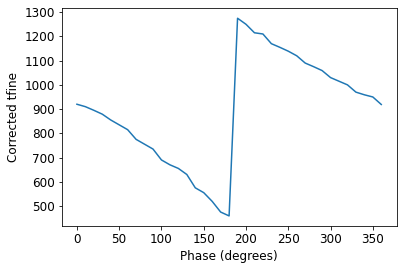

In [12]:
plt.plot(peaks.keys(), peaks.values())
plt.xlabel('Phase (degrees)')
plt.ylabel('Corrected tfine')

Now we have to fit a gaussian for each channel and tac:

In [13]:
def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

In [14]:
from collections import namedtuple
FitFunction = namedtuple('FitFunction', 'fn values errors chi2 pvalue cov'.split())

In [15]:
def fit(func, x, y, seed=(), fit_range=None, **kwargs):
    """
    Fit x, y data to a generic relation of already defined
    python functions.

    Parameters
    ----------
    func : function
        A callable object with signature (x, par0, par1, ...) where x is
        the value (or array of values) at which the function is evaluated
        and par represent the coefficients of the function.
    x, y : iterables
        Data sets to be fitted.
    seed : sequence
        Initial estimation of the fit parameters. Either all or none of them
        must be given.
    fit_range : tuple
        Range of x in which the fit is performed.
    Notes
    -----
    - Functions must be vectorized.

    Returns
    -------
    fitted_fun : extended function (contains values and errors)
        Fitted function.

    Examples
    --------
    >>> import numpy as np
    >>> import invisible_cities.core.fit_functions as fit
    >>> x = np.linspace(-5, 5, 100)
    >>> y = np.exp(-(x-1.)**2)
    >>> f = fit(fit.gauss, x, y, (1., 2., 3))
    >>> print(f.values)
    [ 1.77245385  1.          0.70710678]
    """
    if fit_range is not None:
        sel  = coref.in_range(x, *fit_range)
        x, y = x[sel], y[sel]
        if "sigma" in kwargs:
            kwargs["sigma"] = kwargs["sigma"][sel]

    sigma_r = kwargs.get("sigma", np.ones_like(y))
    if np.any(sigma_r <= 0):
        raise ValueError("Zero or negative value found in argument sigma. "
                         "Errors must be greater than 0.")

    kwargs['absolute_sigma'] = "sigma" in kwargs

    vals, cov = curve_fit(func, x, y, seed, **kwargs)

    fitf       = lambda x: func(x, *vals)
    fitx       = fitf(x)
    errors     = get_errors(cov)
    ndof       = len(y) - len(vals)
    chi2, pval = get_chi2_and_pvalue(y, fitx, ndof, sigma_r)


    return FitFunction(fitf, vals, errors, chi2, pval, cov)


In [16]:
def get_errors(cov):
    """
    Find errors from covariance matrix

    Parameters
    ----------
    cov : np.ndarray
        Covariance matrix of the fit parameters.

    Returns
    -------
    err : 1-dim np.ndarray
        Errors asociated to the fit parameters.
    """
    return np.sqrt(np.diag(cov))

In [17]:
def get_chi2_and_pvalue(ydata, yfit, ndf, sigma=None):
    """
    Gets reduced chi2 and p-value

    Parameters
    ----------
    ydata : np.ndarray
        Data points.
    yfit : np.ndarray
        Fit values corresponding to ydata array.
    sigma : np.ndarray
        Data errors. If sigma is not given, it takes the poisson case:
            sigma = sqrt(ydata)
    ndf : int
        Number of degrees of freedom
        (number of data points - number of parameters).

    Returns
    -------
    chi2 : float
        Reduced chi2 computed as:
            chi2 = [sum(ydata - yfit)**2 / sigma**2] / ndf
    pvalue : float
        Fit p-value.
    """

    if sigma is None:
        sigma = poisson_sigma(ydata)

    chi2   = np.sum(((ydata - yfit) / sigma)**2)
    pvalue = stats.chi2.sf(chi2, ndf)

    return chi2 / ndf, pvalue

In [18]:
def fit_gaussian(values):
    hist_range = [values.min(), values.max()]
    bins = hist_range[1] - hist_range[0]
    
    counts, xedges = np.histogram(values, range=hist_range, bins=bins)
    xstep = xedges[1] - xedges[0]
    xs    = xedges[:-1] + xstep/2
    
    fit_result = fit(gauss, xs, counts, (1., np.mean(tfine_values), np.sqrt(np.var(tfine_values))))
    _, mu, sigma = fit_result.values
    
    plt.plot(xs, fit_result.fn(xs), linewidth=2)
    plt.hist(xs, weights=counts, range=hist_range, bins=bins);

    print('The center of the gaussian fit is', mu)
    print('The sigma of the gaussian fit is', sigma)

The center of the gaussian fit is 952.0859522654929
The sigma of the gaussian fit is 10.250082123849161


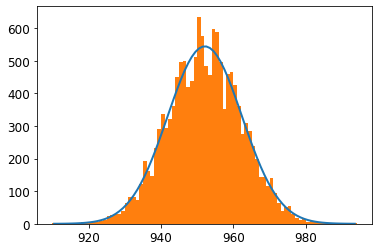

In [19]:
tfine_values = df[(df.delay == 0) & (df.tac_id == 0)].tfine
fit_gaussian(tfine_values)

The center of the gaussian fit is 449.35775725246356
The sigma of the gaussian fit is 12.176363746904276


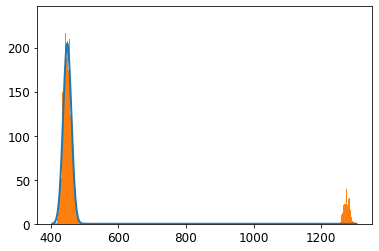

In [20]:
tfine_values = df[(df.delay == 180) & (df.tac_id == 2)].tfine
fit_gaussian(tfine_values)